# Evaluation

The objective of this notebook is to evaluate all the different models. For this project we are going to use several different evaluation metrics:

1. Histogram and see if the proportion of groud truth and prediction is consistent
2. Build confusion matrix
3. Calculate F1 score, Precision, Recall (most important)
4. Decil plots

The Recall metric is one of the most important ones as it will tell us out of all the frauds how many we detected. This is crucial in this kind of problems as it is more painful for a bank to not detect a fraud, than to flag a transaction as fraudulent and in the end not being.

Decil plots will also be useful to see which are the most important decils and the model is most confident on, and how it the model behaves on each section

In [51]:
import seaborn as sns
import pandas as pd
import pickle
import joblib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, roc_curve, roc_auc_score


## Preparing test data and Predictions

Before starting with the evaluations we need to preprocess our test data and prepare it for the predictions

In [52]:
# First we will import all the label encoding models:
categorical_columns = ["transaction_type", "payment_mode", "device_type", "device_location"]
dict_le = dict()
for col in categorical_columns:
    path = f"../utils_models/{col}_LE.joblib"
    le = joblib.load(path)

    dict_le[col] = le

In [53]:
test = pd.read_csv("../data/03_test.csv")

for col in categorical_columns:
    print(f"Encoding column: {col}")
    encoded_col = dict_le[col].transform(test[col])

    test[col] = encoded_col

Encoding column: transaction_type
Encoding column: payment_mode
Encoding column: device_type
Encoding column: device_location


In [54]:
X = test.drop(columns=['transaction_id', 'user_id', 'fraud_label'])
y = test['fraud_label']

### Predictions
Once the data is fully prepared we can start with the predictions

In [55]:
model = joblib.load("../models/rf_20260226.joblib")

y_pred_proba = model.predict_proba(X)

## Histograms
Fist we are going to look at the propostions of predicted fraud and compare it to the ground truth

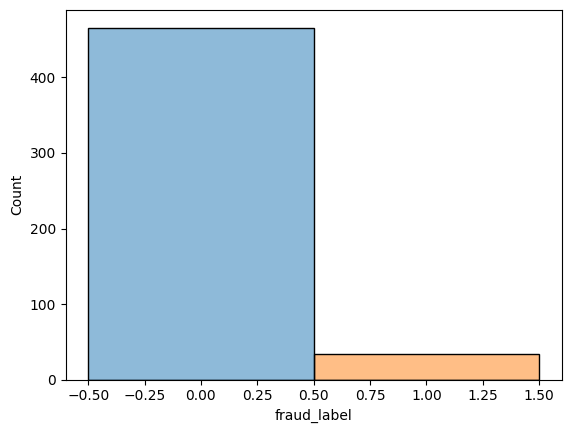

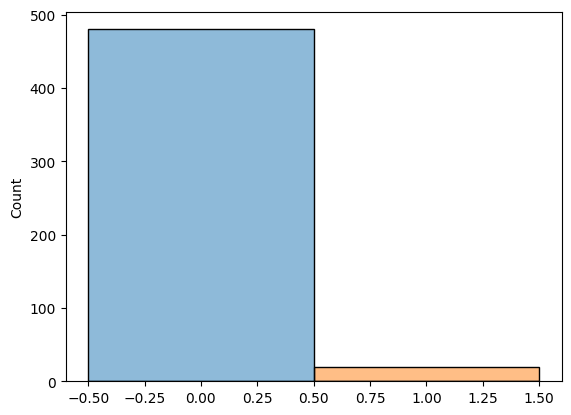

In [56]:
## GROUND TRUTH ##
sns.histplot(
    x=y,
    hue=y,
    discrete=True,  
    palette="tab10", 
    legend=False  
)

plt.show()


## PREDICTIONS ##
y_pred = (y_pred_proba[:, 1] >= 0.5).astype(int)
sns.histplot(
    x=y_pred,
    hue=y_pred,
    discrete=True,  
    palette="tab10", 
    legend=False  
)

plt.show()

## Confusion matrix

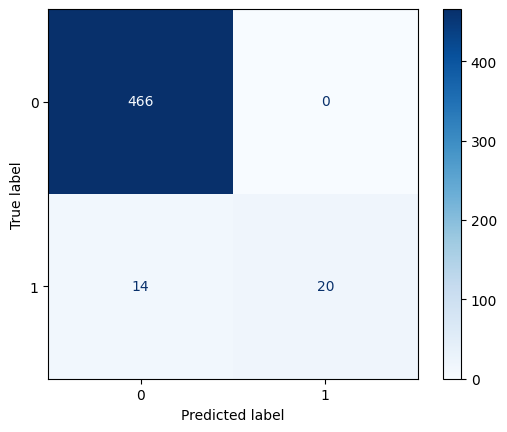

In [57]:
cm = confusion_matrix(y, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.show()

## Metrics

In [58]:
precision = precision_score(y,y_pred)
recall = recall_score(y,y_pred)
f1 = f1_score(y,y_pred)

print(f"The precision of this model is: {precision}")
print(f"The recall of this model is: {recall}")
print(f"The f1 score of this model is: {f1}")

The precision of this model is: 1.0
The recall of this model is: 0.5882352941176471
The f1 score of this model is: 0.7407407407407407


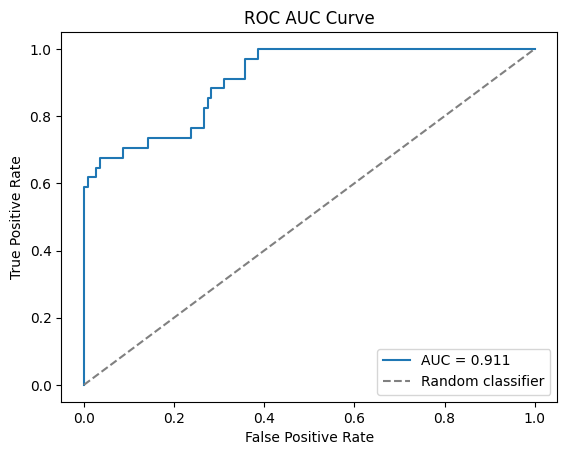

In [59]:
fpr, tpr, thresholds = roc_curve(y, y_pred_proba[:, 1])
auc_score = roc_auc_score(y, y_pred_proba[:, 1])

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey", label="Random classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC Curve")
plt.legend()
plt.show()

## Deciles

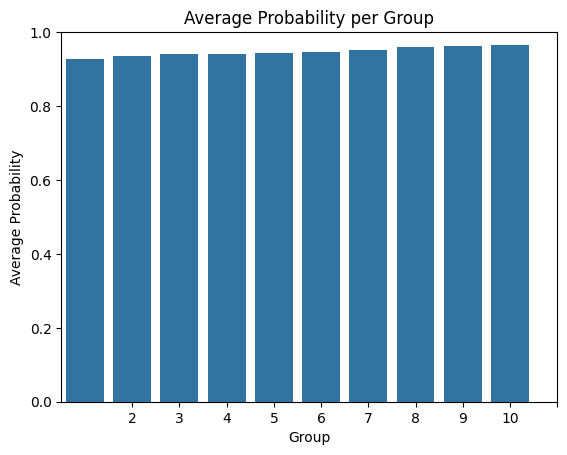

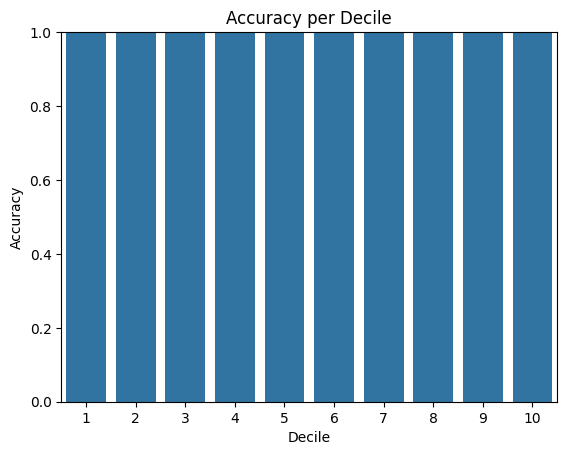

In [82]:
mask = y_pred_proba[:, 1] >= 0.5
y_proba_1 = y_pred_proba[:, 1][mask]
y_true_filtered = np.array(y)[mask]
y_pred_filtered = np.array(y_pred)[mask]

group_indices = pd.qcut(y_proba_1, q=10, labels=False)
avg_probs = pd.Series(y_proba_1).groupby(group_indices).mean()

sns.barplot(x=range(1, 11), y=avg_probs.values)
plt.xlabel("Group")
plt.ylabel("Average Probability")
plt.title("Average Probability per Group")
plt.xticks(range(1, 11))
plt.ylim(0,1)
plt.show()

correct = (y_true_filtered == y_pred_filtered)
accuracy_per_decile = pd.Series(correct).groupby(group_indices).mean()
sns.barplot(x=range(1, 11), y=accuracy_per_decile.values)
plt.xlabel("Decile")
plt.ylabel("Accuracy")
plt.title("Accuracy per Decile")
plt.ylim(0, 1)
plt.show()
